In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import relativedelta
import quandl

import constants
from utils import cached_quandl_get, get_quandl_code

In [2]:
# Plotting setup
style.use('seaborn-poster')
style.use('fivethirtyeight')

# Quandl setup
quandl.ApiConfig.api_key = constants.QUANDL_API_KEY

In [3]:
#r = quandl.get('ZILLOW/M1300_MPPRSF', start_date='2019-01-31', end_date='2019-01-31')

In [4]:
# DATA
SINGLE_FAM_LIST_PRICE_CUT = 'LPCSSF'
SINGLE_FAM_HOME_VAL = 'ZHVISF'
# DATES
START = dt.date(2005, 1, 31)
END = dt.date(2019,1, 31)

# AREAS
AUSTIN_ZIP_CODES = [78610, 78613, 78617, 78641, 78652, 78653, 78660, 78664, 78681, 78701, 78702, 78703, 78704, 78705, 78712, 78717, 78719, 78721, 78722, 78723, 78724, 78725, 78726, 78727, 78728, 78729, 78730, 78731, 78732, 78733, 78734, 78735, 78736, 78737, 78738, 78739, 78741, 78742, 78744, 78745, 78746, 78747, 78748, 78749, 78750, 78751, 78752, 78753, 78754, 78756, 78757, 78758, 78759]


In [5]:
austin_code = get_quandl_code(constants.AREA_COUNTY, constants.TRAVIS_COUNTY, SINGLE_FAM_HOME_VAL)
print(austin_code)

ZILLOW/CO3148_ZHVISF


In [6]:
data = cached_quandl_get(austin_code, start_date=START, end_date=END)

In [7]:
data.head(3)

,Value
Date,
2005-01-31,196700.0
2005-02-28,197600.0
2005-03-31,198400.0


In [8]:
data_norm = data.copy().reset_index()
data_norm['norm value'] = data_norm['Value']/data_norm['Value'][0]

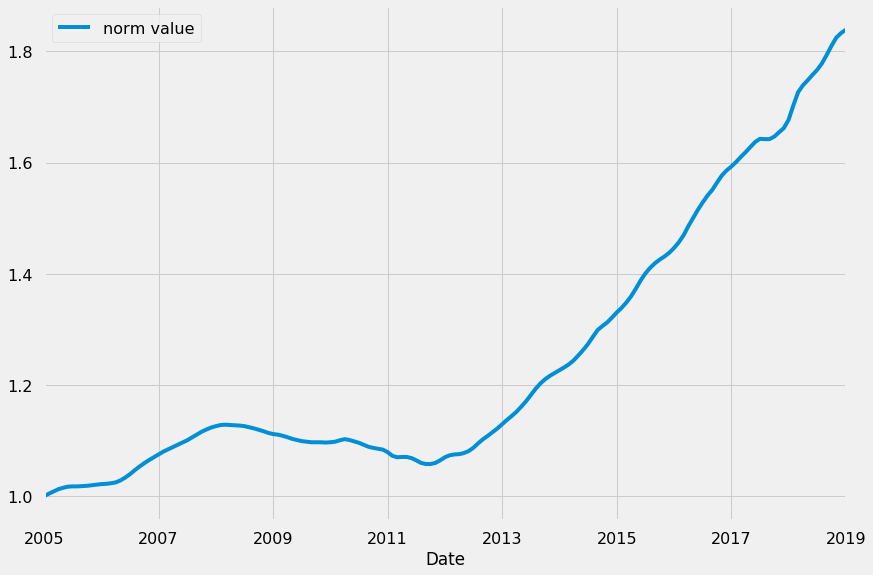

In [9]:
data_norm.reset_index().plot(kind='line', x='Date', y='norm value')
plt.show()

In [10]:
data_yoy = data.copy().reset_index()
data_yoy = data_yoy.groupby(data_yoy['Date'].dt.year).mean().reset_index()
data_yoy['Pct Change'] = data_yoy['Value'].pct_change()*100

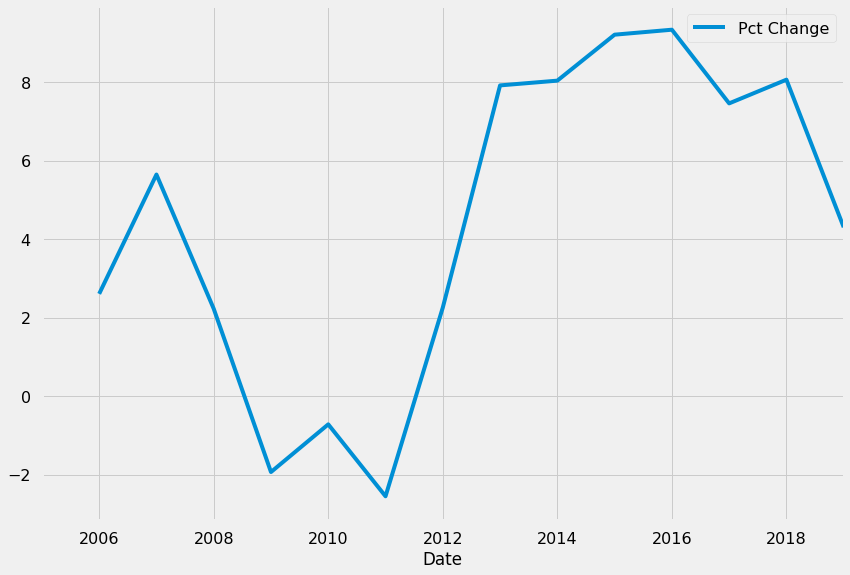

In [11]:
data_yoy.reset_index().plot(kind='line', x='Date', y='Pct Change')
plt.show()

In [12]:
def compare_areas(areas, area_category, indicator_code, args_iterable=(), kwargs_iterable={}):
    dataframes = []
    for area in areas:
        code = get_quandl_code(area_category, area, indicator_code)
        try:
            data = cached_quandl_get(code, *args_iterable, **kwargs_iterable)
            data = data.rename(columns={'Value': area})
            dataframes.append(data)
        except Exception:
            print('unable to fetch {}'.format(code))
    return pd.concat(dataframes, axis=1)

In [14]:
data = compare_areas(
    AUSTIN_ZIP_CODES, 
    constants.AREA_ZIPCODE, 
    SINGLE_FAM_HOME_VAL, 
    kwargs_iterable={'start_date': START, 'end_date': END}
)
for col in data:
    data[col] = data[col]/data[col][0]

unable to fetch ZILLOW/Z78701_ZHVISF
unable to fetch ZILLOW/Z78712_ZHVISF
unable to fetch ZILLOW/Z78719_ZHVISF
unable to fetch ZILLOW/Z78742_ZHVISF


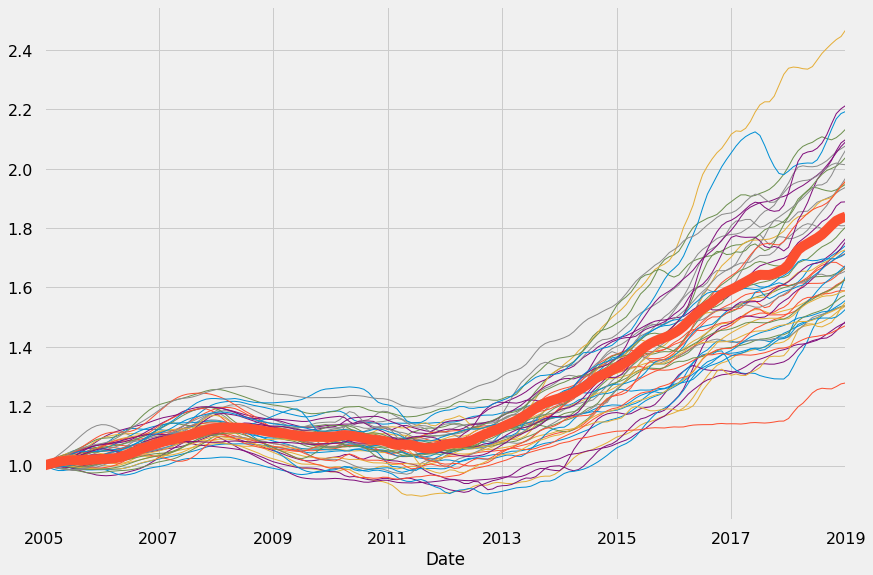

In [15]:
data_with_norm = data.copy().reset_index()
data_with_norm['median value'] = data_norm['norm value']
data_with_norm = data_with_norm.set_index('Date')
line_widths = [1 for _ in data_with_norm.columns]
line_widths[-1] = 10
fig, ax = plt.subplots()
for col, lw in zip(data_with_norm.columns, line_widths):
    data_with_norm.plot(kind='line', y=col, legend=False, linewidth=lw, ax=ax)
plt.show()


In [16]:
end_results = data.T[data.index[-1]]
end_results.describe()

count    49.000000
mean      1.770669
std       0.242165
min       1.278424
25%       1.588418
50%       1.715018
75%       1.957706
max       2.468354
Name: 2019-01-31 00:00:00, dtype: float64

In [17]:
top_25_percentile = end_results.index[end_results.values >= 1.957706]
print(list(top_25_percentile))

[78702, 78703, 78721, 78723, 78736, 78741, 78744, 78745, 78752, 78753, 78757, 78758]


In [18]:
bottom_25_percentile = end_results.index[end_results.values >= 1.588418]
print(list(bottom_25_percentile))

[78610, 78613, 78641, 78652, 78664, 78681, 78702, 78703, 78704, 78705, 78717, 78721, 78722, 78723, 78724, 78727, 78728, 78729, 78731, 78736, 78741, 78744, 78745, 78746, 78747, 78748, 78749, 78750, 78751, 78752, 78753, 78754, 78756, 78757, 78758, 78759]


In [20]:
end_results.argmax()

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  """Entry point for launching an IPython kernel.


78721

In [ ]:
sns.distplot(end_results, bins=10)
plt.show()